In [117]:
# loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

from scipy import stats
from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets

import warnings
warnings.filterwarnings('ignore')

## Introduction

This project utilizes a variety of linear regression algorithms in order to predict the housing price in the city of Boston, or `MEDV`. These are all of the variables in the dataset. This data is maintained in the `datasets` module of `sklearn` but it can also be found online on the UCI Machine Learning Repository or from Kaggle.com. 

    CRIM - per capita crime rate by town
    ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
    INDUS - proportion of non-retail business acres per town.
    CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
    NOX - nitric oxides concentration (parts per 10 million)
    RM - average number of rooms per dwelling
    AGE - proportion of owner-occupied units built prior to 1940
    DIS - weighted distances to five Boston employment centres
    RAD - index of accessibility to radial highways
    TAX - full-value property-tax rate per \$10,000
    PTRATIO - pupil-teacher ratio by town
    B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
    LSTAT - % lower status of the population
    MEDV - Median value of owner-occupied homes in $1000s
    
So first we will read in the data. 

In [118]:
# loading data
boston = datasets.load_boston()
df = pd.DataFrame(boston.data, columns = boston.feature_names)
df['MEDV'] = boston.target

First we can look at the first few observations and also check for any missing values. 

In [119]:
# Looking at the top of the dataset
print(df.head())
# Checking for missing values
print(df.isnull().any())
print(df.shape)

       CRIM    ZN  INDUS  CHAS   NOX    RM   AGE   DIS  RAD    TAX  PTRATIO  \
0  6.32e-03  18.0   2.31   0.0  0.54  6.58  65.2  4.09  1.0  296.0     15.3   
1  2.73e-02   0.0   7.07   0.0  0.47  6.42  78.9  4.97  2.0  242.0     17.8   
2  2.73e-02   0.0   7.07   0.0  0.47  7.18  61.1  4.97  2.0  242.0     17.8   
3  3.24e-02   0.0   2.18   0.0  0.46  7.00  45.8  6.06  3.0  222.0     18.7   
4  6.91e-02   0.0   2.18   0.0  0.46  7.15  54.2  6.06  3.0  222.0     18.7   

        B  LSTAT  MEDV  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
MEDV       False
dtype: bool
(506, 14)


So note that there are no missing variables, although it should be noted that the `CHAS` and `RAD` variables are categorical rather than continuous variables. 

### Data Visualization
As an introductory step it is good to visualize the response variable against the target variables. 

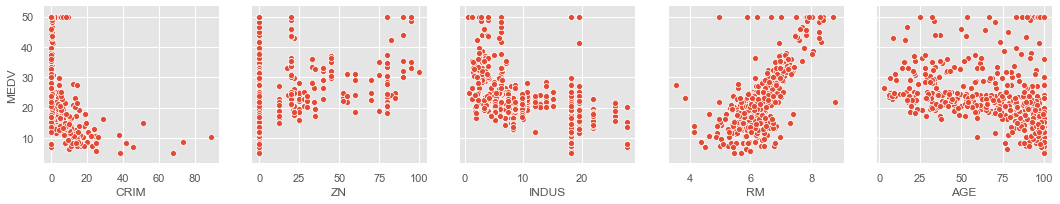

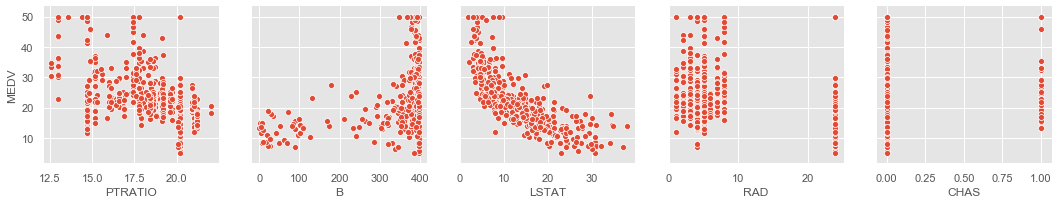

In [120]:
# response vs the continuous target variables
sns.pairplot(data = df, height = 3,
             y_vars = ['MEDV'],
             x_vars = ['CRIM', 'ZN', 'INDUS', 'RM', 'AGE'])

sns.pairplot(data = df, height = 3, y_vars = ['MEDV'],
            x_vars = ['PTRATIO', 'B', 'LSTAT', 'RAD', 'CHAS'])

A cursory glance at the scatterplots of the response and target variables show that `RM` and `LSTAT` have something of a linear relationship with `MEDV`. The rest of the variables don't seem to show much of a correlation. We can scrutinize this further by looking at a correlation matrix. This will help us determine which features to include in the final model, a process known as _feature selection_.

## Feature Selection

### Correlation Matrix
This will tell us if any of the features are highly correlated with one another, which is bad since one of the assumptions of regression is that the features are independent from one another. We can also look at how the response variable correlates with the features. 

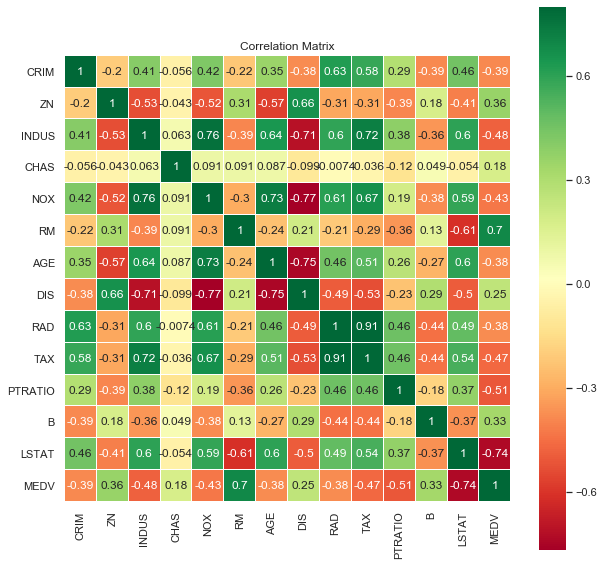

In [121]:
# Setting style for seaborn
sns.set_context("notebook")
sns.set_style("darkgrid")

# 2 significant figures
pd.set_option('precision', 2)

# Correlation matrix
corr = df.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr, vmax = .8, linewidths = 0.01, square = True, annot = True, cmap = 'RdYlGn', linecolor = 'white')
plt.title('Correlation Matrix')
plt.show()

As we expected from our graphs, we notice that the features that correlate the highest with `MEDV` are `RM`, the average number of rooms, and `LSTAT`, the percent lower status of the population.

`DIS`, which is weighted distances to Boston's employment centers, has a strong negative correlation with 3 variables: `INDUS`, the proportion of non-business acres, `NOX`, the concentration of nitric oxides,  and `AGE`, the proportion of homes built before 1940.

### Multicollinearity
In supervised learning, particularly linear regression as we are utilizing here, we don't want to have highly correlated features, otherwise known as _multicollinearity_. In general when building a model you want to have something less complex (i.e. less features) and correlated features tend to give similar information about the response variable. Therefore I am going to check which features have excessive correlation with the other features (> 0.75) and drop them from the dataset. 

In [122]:
# Assigning the response variable as y and the target variables as X
y = df['MEDV']
X = pd.DataFrame(boston.data, columns = boston.feature_names)

# drop features that are highly correlated with other features
# matrix of absolute values of correlation
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.75
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]
to_drop.append('MEDV') # adding response variable to drop list
print(to_drop)

['NOX', 'DIS', 'TAX', 'MEDV']


It appears that `NOX`, `DIS`, and `TAX` are highly correlated with one another so I am going to drop them from the dataset.

Now that we've taken care of that, we want to look at the distribution of the response variable, `MEDV`, by visualizing it in a histogram and a normal probability plot.

In [140]:
# drop the highly correlated features
X = df.drop(df[to_drop], axis = 1)
X.head()

,CRIM,ZN,INDUS,CHAS,RM,AGE,RAD,PTRATIO,B,LSTAT
0,6.32e-03,18.0,2.31,0.0,6.58,65.2,1.0,15.3,396.90,4.98
1,2.73e-02,0.0,7.07,0.0,6.42,78.9,2.0,17.8,396.90,9.14
2,2.73e-02,0.0,7.07,0.0,7.18,61.1,2.0,17.8,392.83,4.03
3,3.24e-02,0.0,2.18,0.0,7.00,45.8,3.0,18.7,394.63,2.94
4,6.91e-02,0.0,2.18,0.0,7.15,54.2,3.0,18.7,396.90,5.33


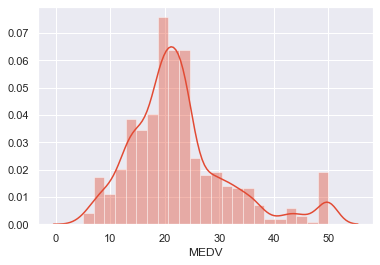

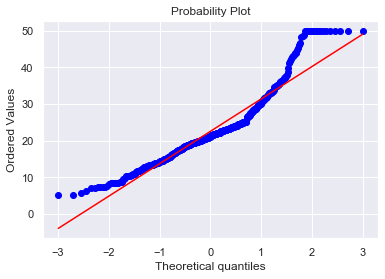

In [124]:
# histogram and normal probability plot
sns.distplot(y, hist = True)
fig = plt.figure()
res = stats.probplot(y, plot = plt)

Notice how the response variable doesn't strictly follow a Normal distribution as it should. Having said that, with such a large sample size of 506, we can forgo this assumption in favor of the Central Limit Theorem which stipulates that the data conforms to a Normal distribution at a large enough sample size.

### Assumptions

To be able to apply linear regression analysis, we have to ensure that the assumptions are fulfilled. These are as follows: 

1. Linearity of the residuals
2. Independence of the residuals
3. Normality of the residuals with a mean of 0
4. Homoskedasticity of the residuals

Out of all of these variables, it appears that the only target variables that actually follow a linear relationship with response variable are `LSTAT` and `RM`, albeit not the most consistent linear relationship. This is commisserate with them having a high correlation with `MEDV` which we saw earlier. We can take this as reason to drop the remaining variables. We can also look more closely at the relationship between `MEDV` and these variables.

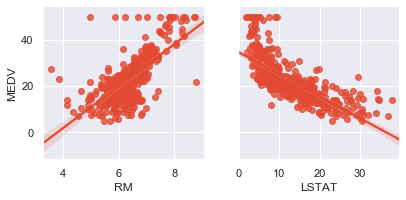

In [125]:
sns.pairplot(data = df, height = 3, 
             y_vars = ['MEDV'], x_vars = ['RM', 'LSTAT'], 
             kind = 'reg')

#### Normality
Now let's look at the distributions of these two variables to see if they follow a Normal distribution. We can also conduct a Shapiro-Wilk test, which tests the null hypothesis that the data is from a Normal distribution. The test returns a W-statistic, which itself has a p-value. If the p-value of the test statistic is below our alpha level of 0.05, then we reject the null hypothesis and conclude that the data is not from a Normal distribution. 

#### The Central Limit Theorem
It is important to point out that while Normality is an assumption, even when it is violated it doesn't necessarily invalidate the model. It is commonly understood that non-Normal residuals is fairly typical in the "real world" and the Central Limit Theorem (which stipulates that data conforms to a Normal distribution at a large enough sample size, generally $n > 15$) generally takes precedence. 

#### Multicollinearity
The third assumption has to do with multicollinearity. We already established early on that several other variables had correlation with one another and dropped those features, and `LSTAT` and `RM` had a moderate correlation coefficient of $-0.61$, which we don't think is enough to consider them multicollinear. 
#### Independent Residuals
Next we need to check that the residuals of the data are independent from each other. Another way to describe this would be autocorrelation of the residuals. We can test this with a Durbin-Watson test. If the test statistic of the test is between 1.5 and 2.5, then there is little to no autocorrelation. Below 2 is considered positive autocorrelation and above 2 is considered negative autocorrelation. 2 would mean no autocorrelation at all. 
#### Training/Test Split
In order to build our model and test it, we do a split of the data between a training set and a test set. Basically when fitting a model, you "train" it on the training set (typically a much bigger subset of the data), then apply the model to the test set. Essentially the model looks at what values for $X$ (target variable(s)) return what values for $y$ (response variable) in the training set, then uses the test set of $X$ values to make predictions for $y$. Then to evaluate the model, we compare the predictions that the model made ($\hat{y}$) against the true values of $y$ (the test set). 

In predicting for continuous variables such as in linear regression, you have a few different metrics to quantify the strength and accuracy of your model. The first is the _Mean Squared Error_, or MSE. It is effectively the average of the squares of the errors, or 

$MSE = \frac{1}{n} \sum(y_i - \hat{y}_i)^2$

where $y_i$ is the true value of the response variable given input $X_i$ and $\hat{y}_i$ is the predicted value. 

It quantifies how far away the predictions are from the true values, and the closer it is to zero, the better. 

_R-squared_ ($R^2$) is the percentage of the variation in the response that is explained by the model, hence it is always between 0 and 1, where 1 means that 100% of the variation in the response is explained by the model. 

After splitting and scaling the data, we can put together a function that builds the model, fits it, calculates the evaluation metrics like the MSE and R-squared, and tests the assumptions. 

In [142]:
# Data Preparation
# only using RM and LSTAT in the model
# X = X[['RM', 'LSTAT']]
print(X.head())
# split between training and testing sets, (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# scaling the data
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

       CRIM    ZN  INDUS  CHAS    RM   AGE  RAD  PTRATIO       B  LSTAT
0  6.32e-03  18.0   2.31   0.0  6.58  65.2  1.0     15.3  396.90   4.98
1  2.73e-02   0.0   7.07   0.0  6.42  78.9  2.0     17.8  396.90   9.14
2  2.73e-02   0.0   7.07   0.0  7.18  61.1  2.0     17.8  392.83   4.03
3  3.24e-02   0.0   2.18   0.0  7.00  45.8  3.0     18.7  394.63   2.94
4  6.91e-02   0.0   2.18   0.0  7.15  54.2  3.0     18.7  396.90   5.33


In [143]:
# function that finds the mean of the residuals, tests for Normality and independence

def residual_tests(residuals):
    
    residuals_mean = round(np.mean(residuals), 3)
    print("{} is the mean of the residuals.".format(residuals_mean))
    
    # Checking for Normality of the residuals, Shapiro-Wilk test
    W_stat, p = stats.shapiro(residuals)
    W_stat = round(W_stat, 3)
    p = round(p, 3)
    print("{} is the test-statistic for the Shapiro-Wilk test with a p-value of {}.".format(W_stat, p))
    if p < 0.05: 
        print("We conclude that the residuals are not Normally distributed.")
    else:
        print("We conclude that the residuals are Normally distributed.")
    
    # Checking independence of the residuals, Durbin-Watson test
    dw = round(durbin_watson(residuals), 3)
    print("{} is the test-statistic for the Durbin-Watson test.".format(dw))
    if dw > 2.5 and dw <= 4:
        print("We conclude there is negative autocorrelation in the residuals.")
    if dw > 0 and dw < 1.5:
        print("We conclude there is positive autocorrelation in the residuals.")
    else:
        print("We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.")

In [144]:
# function that plots the predicted values against the true values, the residual plot, and the QQ-plot of the residuals
# requires seaborn and matplotlib.pyplot

def plot_model_diagnostics(y_pred, y_test, residuals):
    
    # Predictions vs True Values
    plt.figure()
    sns.scatterplot(x = y_pred, y = y_test)
    plt.plot([0, 50], [0, 50], linewidth = 1, color = "blue")
    plt.title("Predictions vs True Values")
    
    # Residual Plot
    plt.figure()
    sns.residplot(x = y_pred, y = y_test, lowess = True)
    plt.title("Residual Plot")
    
    # QQ-plot
    plt.figure()
    stats.probplot(residuals, plot = plt)
    plt.title("QQ-plot of the Residuals")

#### Linear Regression
First we will start with the simplest of machine learning algorithms, the linear regression model. We use the function to fit the model and test it against the assumptions, so that we can evaluate the strength of the model within context. We can also help diagnose model issues by plotting the predictions against the true values and plot the residuals as well.

33.871 is the Mean Squared Error.
0.666 is the R-squared.
0.021 is the mean of the residuals.
0.806 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.148 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


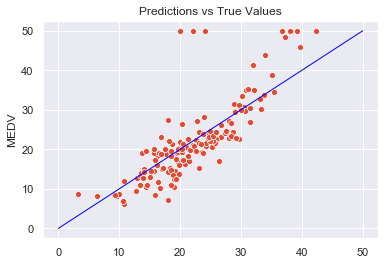

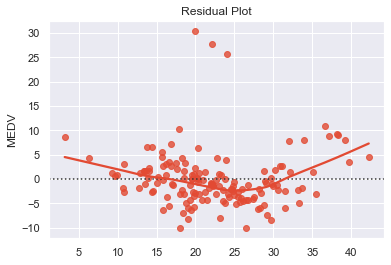

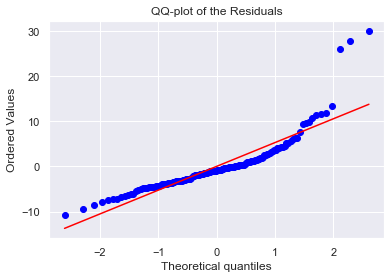

In [145]:
# Linear Regression Model
regr_LR = LinearRegression()
model_LR = regr_LR.fit(X_train, y_train)
predictions_LR = model_LR.predict(X_test)

# MSE 
mse_LR = round(mean_squared_error(y_test, predictions_LR), 3)
print("{} is the Mean Squared Error.".format(mse_LR))

# R-squared
r2_LR = round(model_LR.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_LR))
    
# Residuals
residuals_LR = y_test - predictions_LR
residual_tests(residuals_LR)

# Plotting
plot_model_diagnostics(predictions_LR, y_test, residuals_LR)

Note that the MSE is approximately zero and that the R-squared is 1. This implies that the predictions of the model are exactly in line with the true values, which is most likely too good to be true. 

In the case of the assumptions, we do observe that:

1. The mean of the residuals is approximately 0. 

2. The residuals do NOT follow a Normal distribution since the p-value of the Shapiro-Wilk test is approximately $0 < 0.05$.

3. The Durbin-Watson test returned a test statistic of $1.11 < 1.5$ which implies positive auto-correlation.

Something it is important to note is that although the residuals of the model are not from a Normal distribution, the sample size (504) is sufficiently large enough for us to bypass this assumption. On the other hand, the autocorrelation assumption not being met is more problematic, and is likely one of the explanations for why the MSE and the R-squared seem to indicate such a strong model. This is why assumptions are important to verify rather than to simply take metrics at face value, because they can be misleading and in the face of scrutiny it can be found that the model is not as good as it appears to be.

34.905 is the Mean Squared Error.
0.655 is the R-squared.
-0.15 is the mean of the residuals.
0.861 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.022 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


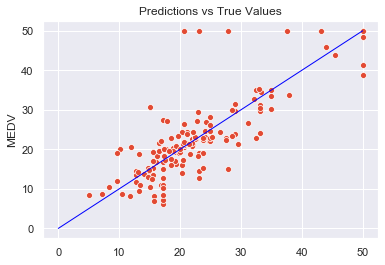

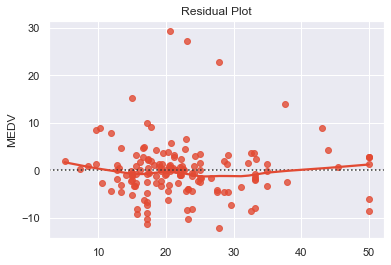

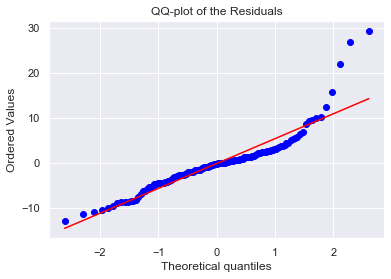

In [146]:
# Decision Tree Regression
regr_DT = DecisionTreeRegressor(random_state = 10)
model_DT = regr_DT.fit(X_train, y_train)
predictions_DT = model_DT.predict(X_test)

# MSE 
mse_DT = round(mean_squared_error(y_test, predictions_DT), 3)
print("{} is the Mean Squared Error.".format(mse_DT))

# R-squared
r2_DT = round(model_DT.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_DT))
    
# Residuals
residuals_DT = y_test - predictions_DT
residual_tests(residuals_DT)

# Plotting
plot_model_diagnostics(predictions_DT, y_test, residuals_DT)

23.88 is the Mean Squared Error.
0.764 is the R-squared.
0.06 is the mean of the residuals.
0.758 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.057 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


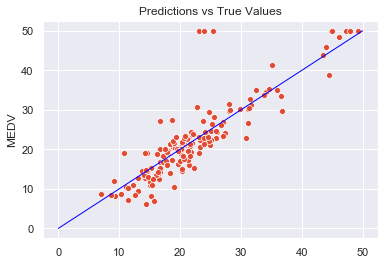

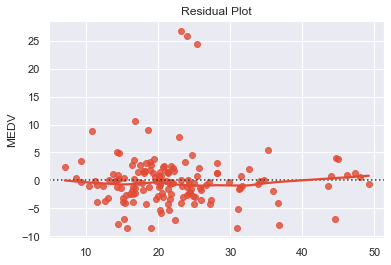

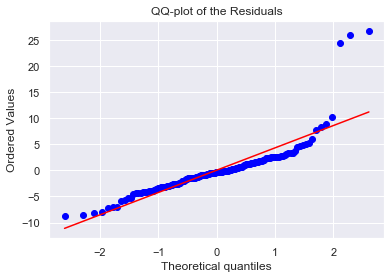

In [147]:
# Random Forest Regressor
regr_RF = RandomForestRegressor()
model_RF = regr_RF.fit(X_train, y_train)
predictions_RF = model_RF.predict(X_test)

# MSE 
mse_RF = round(mean_squared_error(y_test, predictions_RF), 3)
print("{} is the Mean Squared Error.".format(mse_RF))

# R-squared
r2_RF = round(model_RF.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_RF))
    
# Residuals
residuals_RF = y_test - predictions_RF
residual_tests(residuals_RF)

# Plotting
plot_model_diagnostics(predictions_RF, y_test, residuals_RF)

31.009 is the Mean Squared Error.
0.694 is the R-squared.
0.677 is the mean of the residuals.
0.775 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.117 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


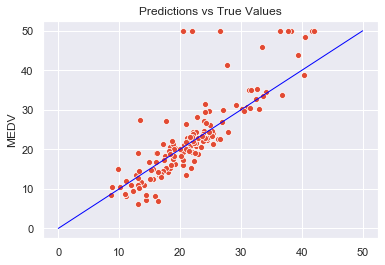

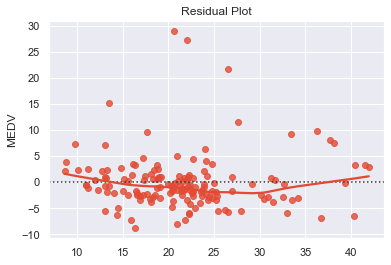

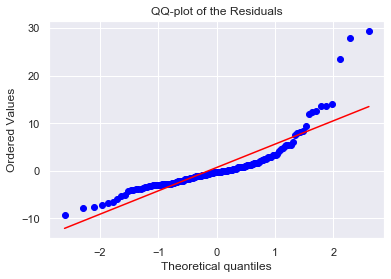

In [148]:
# KNN Regression
regr_KNN = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', algorithm = 'auto')
model_KNN = regr_KNN.fit(X_train, y_train)
predictions_KNN = model_KNN.predict(X_test)

# MSE 
mse_KNN = round(mean_squared_error(y_test, predictions_KNN), 3)
print("{} is the Mean Squared Error.".format(mse_KNN))

# R-squared
r2_KNN = round(model_KNN.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_KNN))
    
# Residuals
residuals_KNN = y_test - predictions_KNN
residual_tests(residuals_KNN)

# Plotting
plot_model_diagnostics(predictions_KNN, y_test, residuals_KNN)

33.892 is the Mean Squared Error.
0.665 is the R-squared.
0.022 is the mean of the residuals.
0.805 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.148 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


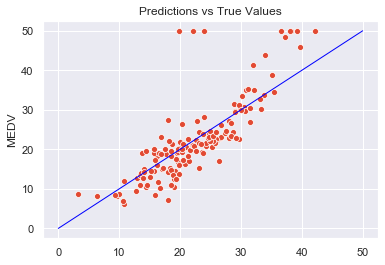

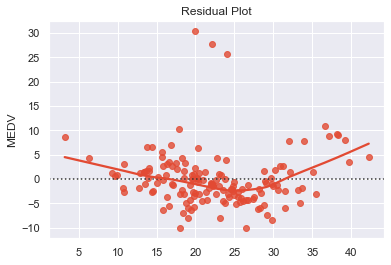

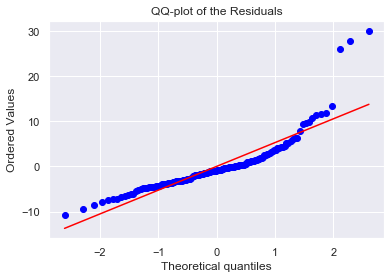

In [149]:
# Ridge Regression
regr_Ridge = Ridge(alpha = 0.5, random_state = 10)
model_Ridge = regr_Ridge.fit(X_train, y_train)
predictions_Ridge = model_Ridge.predict(X_test)

# MSE 
mse_Ridge = round(mean_squared_error(y_test, predictions_Ridge), 3)
print("{} is the Mean Squared Error.".format(mse_Ridge))

# R-squared
r2_Ridge = round(model_Ridge.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_Ridge))
    
# Residuals
residuals_Ridge = y_test - predictions_Ridge
residual_tests(residuals_Ridge)

# Plotting
plot_model_diagnostics(predictions_Ridge, y_test, residuals_Ridge)

36.063 is the Mean Squared Error.
0.644 is the R-squared.
-0.057 is the mean of the residuals.
0.796 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.142 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


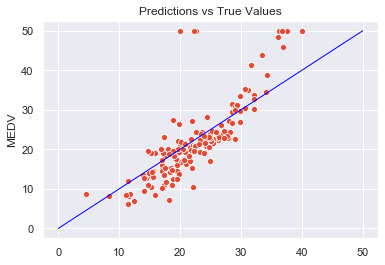

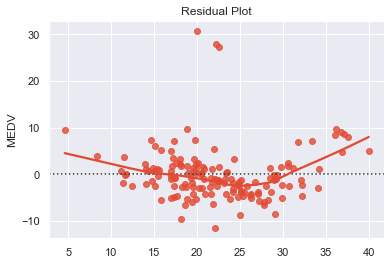

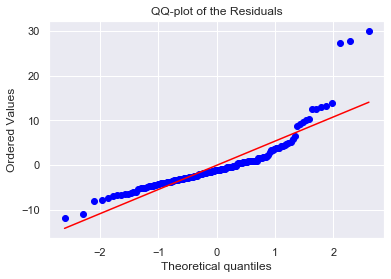

In [150]:
# Lasso Regression
regr_Lasso = Lasso(alpha = 0.5, random_state = 10)
model_Lasso = regr_Lasso.fit(X_train, y_train)
predictions_Lasso = model_Lasso.predict(X_test)

# MSE 
mse_Lasso = round(mean_squared_error(y_test, predictions_Lasso), 3)
print("{} is the Mean Squared Error.".format(mse_Lasso))

# R-squared
r2_Lasso = round(model_Lasso.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_Lasso))
    
# Residuals
residuals_Lasso = y_test - predictions_Lasso
residual_tests(residuals_Lasso)

# Plotting
plot_model_diagnostics(predictions_Lasso, y_test, residuals_Lasso)

{'alpha': 0.001, 'l1_ratio': 0.6}
33.871 is the Mean Squared Error.
0.666 is the R-squared.
0.021 is the mean of the residuals.
0.806 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
2.148 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


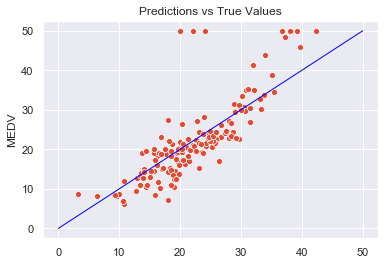

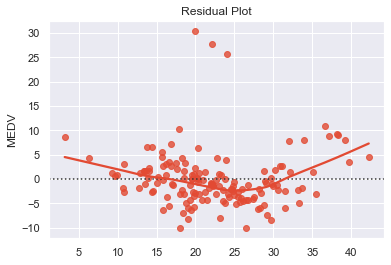

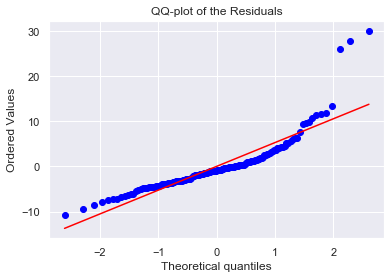

In [151]:
# Elastic Net Regression

# find the best hyperparameters
elastic = ElasticNet(normalize = True)
search = GridSearchCV(estimator = elastic,
                    param_grid = {'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},
                    scoring = 'neg_mean_squared_error',n_jobs = 1,refit = True,cv = 10)
search.fit(X_train, y_train)
print(search.best_params_)

# Fitting the model
regr_Elastic = ElasticNet(normalize = True, alpha = 0, l1_ratio = 0.8)
model_Elastic = regr_Elastic.fit(X_train, y_train)
predictions_Elastic = model_Elastic.predict(X_test)

# MSE 
mse_Elastic = round(mean_squared_error(y_test, predictions_Elastic), 3)
print("{} is the Mean Squared Error.".format(mse_Elastic))

# R-squared
r2_Elastic = round(model_Elastic.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_Elastic))
    
# Residuals
residuals_Elastic = y_test - predictions_Elastic
residual_tests(residuals_Elastic)

# Plotting
plot_model_diagnostics(predictions_Elastic, y_test, residuals_Elastic)

20.549 is the Mean Squared Error.
0.797 is the R-squared.
0.188 is the mean of the residuals.
0.734 is the test-statistic for the Shapiro-Wilk test with a p-value of 0.0.
We conclude that the residuals are not Normally distributed.
1.924 is the test-statistic for the Durbin-Watson test.
We conclude there is little to no autocorrelation in the residuals and therefore they are independently distributed.


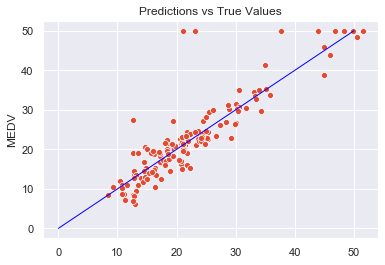

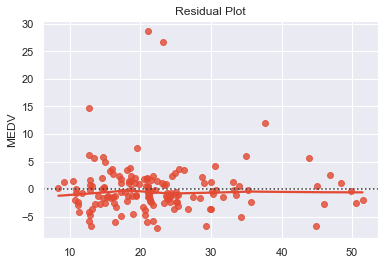

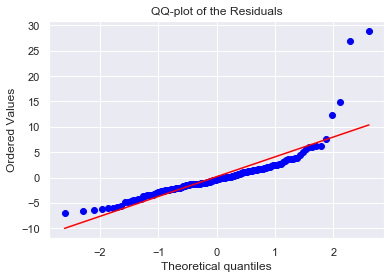

In [152]:
# Gradient Boosting Regressor
regr_GBR = GradientBoostingRegressor(random_state = 10, n_estimators = 400)
model_GBR = regr_GBR.fit(X_train, y_train)
predictions_GBR = model_GBR.predict(X_test)

# MSE 
mse_GBR = round(mean_squared_error(y_test, predictions_GBR), 3)
print("{} is the Mean Squared Error.".format(mse_GBR))

# R-squared
r2_GBR = round(model_GBR.score(X_test, y_test), 3)
print("{} is the R-squared.".format(r2_GBR))
    
# Residuals
residuals_GBR = y_test - predictions_GBR
residual_tests(residuals_GBR)

# Plotting
plot_model_diagnostics(predictions_GBR, y_test, residuals_GBR)

### Comparing Algorithms

Now that we have calculated the MSE and the R-squared for all of the different models, we want to compare them. We want to minimize the MSE and maximize the R-squared. In order to pick the best model, we can plot these two values for each of the models onto a scatterplot. The best model would have a low MSE and a high R2, so ideally it would be in the upper left quadrant of the plot, where MSE is on the x-axis and R-squared in on the y-axis.

             Algorithm    MSE    R2
0    Linear Regression  33.87  0.67
1        Decision Tree  34.91  0.66
2        Random Forest  23.88  0.76
3  k-Nearest Neighbors  31.01  0.69
4                LASSO  36.06  0.64
5                Ridge  33.89  0.67
6          Elastic Net  33.87  0.67
7    Gradient Boosting  20.55  0.80


Text(0.5, 1.0, 'MSE vs R-squared, by Algorithm')

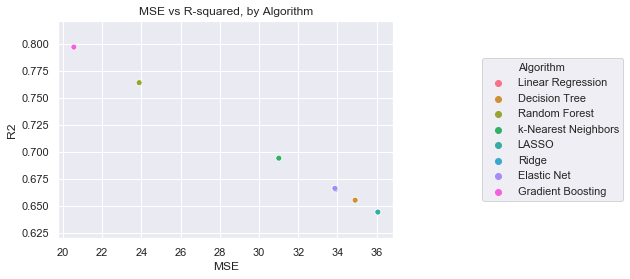

In [153]:
# Initializing a matrix that will be filled with MSE and R-squared
records = []
algorithms = ('Linear Regression', 'Decision Tree', 'Random Forest',
              'k-Nearest Neighbors', 'LASSO', 'Ridge', 'Elastic Net', 'Gradient Boosting')
mse_all = (mse_LR, mse_DT, mse_RF, mse_KNN, mse_Lasso, mse_Ridge, mse_Elastic, mse_GBR)
r2_all = (r2_LR, r2_DT, r2_RF, r2_KNN, r2_Lasso, r2_Ridge, r2_Elastic, r2_GBR)

# Filling matrix in with values
for i in range(0,8):
    records.append({'Algorithm': algorithms[i],
                   'MSE': mse_all[i],
                   'R2': r2_all[i]})

# converting into a DataFrame
records = pd.DataFrame(records)
print(records)

# plotting
plt.figure()
g = sns.scatterplot(x = 'MSE', y = 'R2', data = records, hue = 'Algorithm')
g.legend(loc = 'center left', bbox_to_anchor = (1.25, 0.5), ncol = 1)
plt.title('MSE vs R-squared, by Algorithm')

As we can see, the best performing model is the Gradient Boosting algorithm. Note the clear negative correlation between R2 and MSE. This makes sense since the greater the error of the model (MSE), the less variance in the response variable that would be explained by the predictors (R-squared). 